In [1]:
%matplotlib inline

#Source code with the blog post at http://monik.in/a-noobs-guide-to-implementing-rnn-lstm-using-tensorflow/
import numpy as np
import random
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.special as sps
from IPython import display
import time


In [13]:
def load_keystrokes(log_file):
    #these numbers affect the caps on normalized values (anything over max = 1)
    MAX_CHAR = 255
    MIN_CHAR = 0

    # likewise anything under min is 0
    MIN_TIME = 10
    MAX_TIME = 5000

    IN_FILE = log_file
    OUT_FILE = "normal_"+log_file

    import math

    def gaus_norm(x, MIN, MAX):
        return (float(x - MIN)/float(MAX-MIN))
    
    data = []
    with open(IN_FILE, 'r') as fin:
        for i, line in enumerate(fin):
            time, char = line.split(',')
            time, char = int(time), int(char)
            if i == 0 :
                last_char = char
                continue
            if time > MAX_TIME or time < MIN_TIME:
                #print('time error value [{}] found, skipping'.format(time))
                continue
            else:
                    new_time = gaus_norm(time, MIN_TIME, MAX_TIME)
                    new_char = gaus_norm(char, MIN_CHAR, MAX_CHAR)
                    new_last_char = gaus_norm(last_char, MIN_CHAR, MAX_CHAR)
                    data.append([new_last_char, new_time, new_char])
    data_count = len(data)
    data = [x for x in data if x[1] > 0]
    clean_data_count = len(data)

    print("Loaded {} events, {} removed".format(clean_data_count, data_count - clean_data_count))
    return data

positive_data = load_keystrokes("key_logging/robert_stroke.log")
negative_data = load_keystrokes("key_logging/david_keystroke.log")

Loaded 52523 events, 1 removed
Loaded 100783 events, 13 removed


In [3]:
# muddle positive time_delta data to generate negative samples
NUM_EXAMPLES = 100000
SEQ_LENGTH = 50

assert all(len(data) >= SEQ_LENGTH for data in [positive_data, negative_data]), 'need at least SEQ_LENGTH events'

def random_sub_seq(xs):
    # TODO extend to support variable size sequences
    start = int(np.random.uniform(0, len(xs) - SEQ_LENGTH))
    end = start + SEQ_LENGTH
    return xs[start:end]

train_input = []
train_output = []

for i in range(NUM_EXAMPLES * 10):
    if np.random.rand() < 0.5:
        # positive sample
        train_input.append(random_sub_seq(positive_data))
        train_output.append([1, 0])
    else:
        # negative sample
        train_input.append(random_sub_seq(negative_data))
        train_output.append([0, 1])

In [4]:
test_input = train_input[NUM_EXAMPLES:]
test_output = train_output[NUM_EXAMPLES:]
train_input = train_input[:NUM_EXAMPLES]
train_output = train_output[:NUM_EXAMPLES]

print("test and training data loaded")

test and training data loaded


In [5]:
data = tf.placeholder(tf.float32, [None, SEQ_LENGTH,3]) #Number of examples, number of input, dimension of each input
target = tf.placeholder(tf.float32, [None, 2])
num_hidden = 32
cell = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
val, _ = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)
weight = tf.Variable(tf.truncated_normal([num_hidden, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))
prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
cross_entropy = -tf.reduce_sum(target * tf.log(prediction))
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(cross_entropy)
mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [6]:
sess = tf.Session()
saver = tf.train.Saver()

In [7]:
saver.restore(sess, "./model_normal.ckpt")
print("Model restored.")

Model restored.


In [8]:
good = [test_input[i] for i in range(len(test_output)) if test_output[i] == [1, 0]]
bad = [test_input[i] for i in range(len(test_output)) if test_output[i] == [0, 1]]

In [9]:
print("true positive: ", sess.run(prediction,{data: good}).mean(axis=0)[0])
print("true negative: ", sess.run(prediction,{data: bad}).mean(axis=0)[1])

true positive:  0.992866
true negative:  0.986786


In [10]:
print(len(good), len(bad))

449130 450870


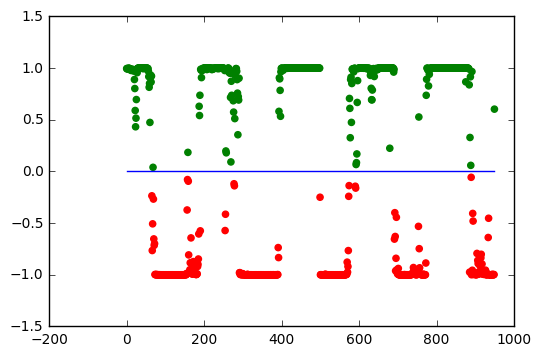

In [11]:
history = []

data_source = positive_data
data_len = 100

for i in range(10):
    history += data_source[i * data_len: (i+1) * data_len]
        
    if data_source == positive_data:
        data_source = negative_data
    else:
        data_source = positive_data
        
prediction_history = []
for i in range(0, len(history) - SEQ_LENGTH):
    sample = history[i: i + SEQ_LENGTH]
    result = sess.run(prediction,{data: [sample]})[0]
    prediction_history.append((result[0] - 0.5) * 2)
    
plt.scatter(range(len(prediction_history)), prediction_history, color=['g' if h > 0 else 'r' for h in prediction_history])
plt.plot([0] * len(prediction_history), color='b')